# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

from scipy.cluster.vq import whiten
X_train = whiten(X_train)
X_test = whiten(X_test)

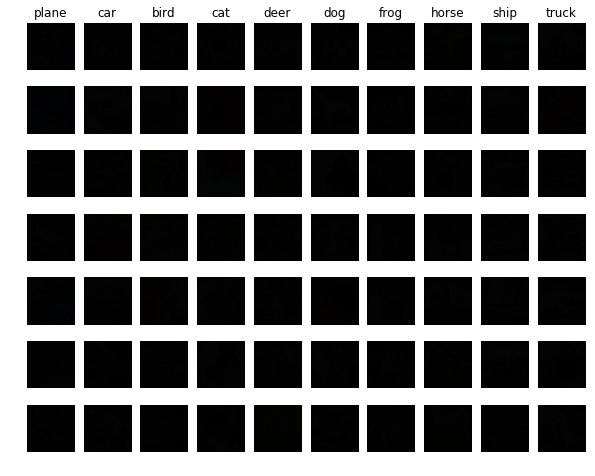

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Они глубокие. Очень глубокие.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Они могут плохо учиться, потому что из-за их большой глубины происходит затухание градиента

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?

<Ответ>

**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [4]:
#!export LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64:$LD_LIBRARY_PATH
#!export PATH=/usr/local/cuda-8.0/bin:$PATH

import theano
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Wish you get fun :)

In [52]:
# GoogleNet trainable

from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import ConcatLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers.dnn import MaxPool2DDNNLayer as MaxPool
from lasagne.layers.dnn import Pool2DDNNLayer as Pool
from lasagne.layers.dnn import BatchNormDNNLayer as BatchNormLayer
from lasagne.nonlinearities import softmax, linear

net = InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
net = ConvLayer(net, num_filters=64, filter_size=(7, 7), pad=3, stride=(2, 2),\
                nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(), b=None, name='conv1')
net = BatchNormLayer(net, name='conv1_bn')
net = NonlinearityLayer(net, nonlinearity=lasagne.nonlinearities.rectify, name='conv1_relu')
net = MaxPool(net, pool_size=(3, 3), pad=1, stride=(2, 2), name='pool1')

net = ConvLayer(net, num_filters=64, filter_size=(1, 1),\
                nonlinearity=lasagne.nonlinearities.identity, \
                W=lasagne.init.GlorotUniform(), b=None, name='conv2_reduce')
net = BatchNormLayer(net, name='conv2_reduce_bn')
net = NonlinearityLayer(net, nonlinearity=lasagne.nonlinearities.rectify,\
    name='conv2_reduce_relu')

net = ConvLayer(net, num_filters=192, filter_size=(3, 3), pad=1,\
                nonlinearity=lasagne.nonlinearities.identity, \
                W=lasagne.init.GlorotUniform(), b=None, name='conv2')
net = BatchNormLayer(net, name='conv2_bn')
net = NonlinearityLayer(net, nonlinearity=lasagne.nonlinearities.rectify,\
    name='conv2_relu')
net = MaxPool(net, pool_size=(3, 3), pad=1, stride=(2, 2), name='pool2')

##### incetpion module 3a #####

inception_1x1 = ConvLayer(net, num_filters=64, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, name='inception_3a_1x1')
inception_1x1 = BatchNormLayer(inception_1x1, name='inception_3a_1x1_bn')
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     name='inception_3a_1x1_relu')

inception_3x3 = ConvLayer(net,num_filters=96,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_3x3 = BatchNormLayer(inception_3x3, name='inception_3a_3x3_reduce_bn')
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       name='inception_3a_3x3_reduce_relu')
inception_3x3 = ConvLayer(inception_3x3, num_filters=128, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, name='inception_3a_3x3')
inception_3x3 = BatchNormLayer( inception_3x3, name='inception_3a_3x3_bn')
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       name='inception_3a_3x3_relu')

inception_5x5 = ConvLayer(net,num_filters=16,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_5x5 = BatchNormLayer(inception_5x5, name='inception_3a_3x3_reduce_bn')
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       name='inception_3a_3x3_reduce_relu')
inception_5x5 = ConvLayer(inception_5x5, num_filters=32, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, name='inception_3a_3x3')
inception_5x5 = BatchNormLayer( inception_5x5, name='inception_3a_3x3_bn')
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       name='inception_3a_3x3_relu')

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), name='inception_3a_pool')
inception_pool = ConvLayer(inception_pool, num_filters=32, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, name='inception_3a_1x1')
inception_pool = BatchNormLayer(inception_pool, name='inception_3a_1x1_bn')
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     name='inception_3a_1x1_relu')

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1, name='inception_3a_output')
###############################

##### incetpion module 3b #####

inception_1x1 = ConvLayer(net, num_filters=128, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=128,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=192, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=32,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=96, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_5x5 = BatchNormLayer( inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), )
inception_pool = ConvLayer(inception_pool, num_filters=64, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool,)
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )
net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1, )
###############################

In [53]:
net = MaxPool(net, pool_size=(3, 3),pad=1,stride=(2, 2),)
##### incetpion module 4a #####

inception_1x1 = ConvLayer(net, num_filters=192, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=96,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=208, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=16,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=48, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_5x5 = BatchNormLayer( inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), )
inception_pool = ConvLayer(inception_pool, num_filters=64, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool, )
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1, )
###############################

##### first output #####

loss_1_layer = Pool(net, pool_size=(5, 5), stride=(3, 3), pad=(2, 2), mode='average_inc_pad', )
loss_1_layer = ConvLayer(loss_1_layer, num_filters=128, filter_size=(1, 1), nonlinearity=lasagne.nonlinearities.identity,
                   W=lasagne.init.GlorotUniform(), b=None, )
loss_1_layer = BatchNormLayer(loss_1_layer, )
loss_1_layer = NonlinearityLayer(loss_1_layer, nonlinearity=lasagne.nonlinearities.rectify,\
                                 )

loss_1_layer = DenseLayer(loss_1_layer, num_units=1024, nonlinearity=lasagne.nonlinearities.identity,\
                          W=lasagne.init.GlorotUniform(), b=None,)
loss_1_layer = BatchNormLayer(loss_1_layer, )
loss_1_layer = NonlinearityLayer(loss_1_layer, nonlinearity=lasagne.nonlinearities.rectify,\
                                 )

loss_1_layer = DenseLayer(loss_1_layer, num_units=10, nonlinearity=lasagne.nonlinearities.softmax,\
                          W=lasagne.init.GlorotUniform(), )

loss1_probs = lasagne.layers.get_output(loss_1_layer)#, lasagne.layers.get_output(l_in))
loss1 = lasagne.objectives.categorical_crossentropy(loss1_probs, target_y).mean()

loss1_preds_top1 = theano.tensor.argmax(loss1_probs, axis=1)
loss1_acc_top1 = theano.tensor.mean(theano.tensor.eq(loss1_preds_top1, target_y), \
                                    dtype=theano.config.floatX)
loss1_preds_top5 = theano.tensor.argsort(loss1_probs, axis=1)[:,:5]
loss1_acc_top5 = theano.tensor.mean(
    theano.tensor.eq(loss1_preds_top5[:,0], target_y) + 
    theano.tensor.eq(loss1_preds_top5[:,1], target_y) +
    theano.tensor.eq(loss1_preds_top5[:,2], target_y) +
    theano.tensor.eq(loss1_preds_top5[:,3], target_y) +
    theano.tensor.eq(loss1_preds_top5[:,4], target_y),
    dtype=theano.config.floatX)

#######################


In [54]:
##### incetpion module 4b #####

inception_1x1 = ConvLayer(net, num_filters=160, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=112,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None)
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=224, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, name='inception_3a_3x3')
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=24,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=64, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_5x5 = BatchNormLayer( inception_5x5,)
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), )
inception_pool = ConvLayer(inception_pool, num_filters=64, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool, )
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1,)
###############################


In [55]:
##### incetpion module 4c #####

inception_1x1 = ConvLayer(net, num_filters=128, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=128,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=256, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=24,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,)
inception_5x5 = ConvLayer(inception_5x5, num_filters=64, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_5x5 = BatchNormLayer( inception_5x5,)
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify)

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1),)
inception_pool = ConvLayer(inception_pool, num_filters=64, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None,)
inception_pool = BatchNormLayer(inception_pool,)
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                    )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1,)
###############################


In [56]:
##### incetpion module 4d #####

inception_1x1 = ConvLayer(net, num_filters=128, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=128,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=256, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=24,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=64, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_5x5 = BatchNormLayer( inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), )
inception_pool = ConvLayer(inception_pool, num_filters=64, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool)
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1)
###############################

##### second output #####
loss_2_layer = Pool(net, pool_size=(5, 5), stride=(3, 3), pad=(2, 2), mode='average_inc_pad', )
loss_2_layer = ConvLayer(loss_2_layer, num_filters=128, filter_size=(1, 1), nonlinearity=lasagne.nonlinearities.identity,
                   W=lasagne.init.GlorotUniform(), b=None, )
loss_2_layer = BatchNormLayer(loss_2_layer, )
loss_2_layer = NonlinearityLayer(loss_2_layer, nonlinearity=lasagne.nonlinearities.rectify,\
                                 )

loss_2_layer = DenseLayer(loss_2_layer, num_units=1024, nonlinearity=lasagne.nonlinearities.identity,\
                          W=lasagne.init.GlorotUniform(), b=None, )
loss_2_layer = BatchNormLayer(loss_2_layer,)
loss_2_layer = NonlinearityLayer(loss_2_layer, nonlinearity=lasagne.nonlinearities.rectify,\
                                 )

loss_2_layer = DenseLayer(loss_2_layer, num_units=10, nonlinearity=lasagne.nonlinearities.softmax,\
                          W=lasagne.init.GlorotUniform(),)

loss2_probs = lasagne.layers.get_output(loss_2_layer)#, lasagne.layers.get_output(l_in))
loss2 = lasagne.objectives.categorical_crossentropy(loss2_probs, target_y).mean()

loss2_preds_top1 = theano.tensor.argmax(loss2_probs, axis=1)
loss2_acc_top1 = theano.tensor.mean(theano.tensor.eq(loss2_preds_top1, target_y), \
                                    dtype=theano.config.floatX)
loss2_preds_top5 = theano.tensor.argsort(loss2_probs, axis=1)[:,:5]
loss2_acc_top5 = theano.tensor.mean(
    theano.tensor.eq(loss2_preds_top5[:,0], target_y) + 
    theano.tensor.eq(loss2_preds_top5[:,1], target_y) +
    theano.tensor.eq(loss2_preds_top5[:,2], target_y) +
    theano.tensor.eq(loss2_preds_top5[:,3], target_y) +
    theano.tensor.eq(loss2_preds_top5[:,4], target_y),
    dtype=theano.config.floatX)

In [57]:
##### incetpion module 4e #####

inception_1x1 = ConvLayer(net, num_filters=256, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=160,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=320, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=32,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,)
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=128, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_5x5 = BatchNormLayer( inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1),)
inception_pool = ConvLayer(inception_pool, num_filters=128, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool)
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1)
###############################

In [58]:
net = MaxPool(net, pool_size=(3, 3),pad=1,stride=(2, 2))

##### incetpion module 5a #####

inception_1x1 = ConvLayer(net, num_filters=256, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=160,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=320, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=32,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=128, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, name='inception_3a_3x3')
inception_5x5 = BatchNormLayer( inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), name='inception_3a_pool')
inception_pool = ConvLayer(inception_pool, num_filters=128, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool)
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1)
###############################

##### incetpion module 5b #####

inception_1x1 = ConvLayer(net, num_filters=384, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_1x1 = BatchNormLayer(inception_1x1, )
inception_1x1 = NonlinearityLayer(inception_1x1, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

inception_3x3 = ConvLayer(net,num_filters=192,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_3x3 = BatchNormLayer(inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_3x3 = ConvLayer(inception_3x3, num_filters=384, filter_size=(3, 3),\
                               pad=1, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, )
inception_3x3 = BatchNormLayer( inception_3x3, )
inception_3x3 = NonlinearityLayer(inception_3x3, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_5x5 = ConvLayer(net,num_filters=48,filter_size=(1, 1),\
                               nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None,name='inception_3a_3x3_reduce')
inception_5x5 = BatchNormLayer(inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )
inception_5x5 = ConvLayer(inception_5x5, num_filters=128, filter_size=(5, 5),\
                               pad=2, nonlinearity=lasagne.nonlinearities.identity,\
                               W=lasagne.init.GlorotUniform(), b=None, name='inception_3a_3x3')
inception_5x5 = BatchNormLayer( inception_5x5, )
inception_5x5 = NonlinearityLayer(inception_5x5, nonlinearity=lasagne.nonlinearities.rectify,\
                                       )

inception_pool = MaxPool(net, pool_size=(3, 3), pad=1, stride=(1, 1), name='inception_3a_pool')
inception_pool = ConvLayer(inception_pool, num_filters=128, filter_size=(1, 1),\
                             nonlinearity=lasagne.nonlinearities.identity, W=lasagne.init.GlorotUniform(),\
                             b=None, )
inception_pool = BatchNormLayer(inception_pool)
inception_pool = NonlinearityLayer(inception_pool, nonlinearity=lasagne.nonlinearities.rectify,\
                                     )

net = ConcatLayer(incomings=[inception_1x1, inception_3x3, inception_5x5, inception_pool],\
                 axis=1)
###############################

In [59]:
loss_3_layer = Pool(net, pool_size=(5, 5), stride=(3, 3), pad=(2, 2), mode='average_inc_pad')
loss_3_layer = ConvLayer(loss_3_layer, num_filters=128, filter_size=(1, 1), nonlinearity=lasagne.nonlinearities.identity,
                   W=lasagne.init.GlorotUniform(), b=None)
loss_3_layer = BatchNormLayer(loss_3_layer)
loss_3_layer = NonlinearityLayer(loss_3_layer, nonlinearity=lasagne.nonlinearities.rectify)

loss_3_layer = DenseLayer(loss_3_layer, num_units=1024, nonlinearity=lasagne.nonlinearities.identity,\
                          W=lasagne.init.GlorotUniform(), b=None)
loss_3_layer = BatchNormLayer(loss_3_layer)
loss_3_layer = NonlinearityLayer(loss_3_layer, nonlinearity=lasagne.nonlinearities.rectify)

loss_3_layer = DenseLayer(loss_3_layer, num_units=10, nonlinearity=lasagne.nonlinearities.softmax,\
                          W=lasagne.init.GlorotUniform())

loss3_probs = lasagne.layers.get_output(loss_3_layer)#, lasagne.layers.get_output(l_in))
loss3 = lasagne.objectives.categorical_crossentropy(loss3_probs, target_y).mean()

loss3_preds_top1 = theano.tensor.argmax(loss3_probs, axis=1)
loss3_acc_top1 = theano.tensor.mean(theano.tensor.eq(loss2_preds_top1, target_y), \
                                    dtype=theano.config.floatX)
loss3_preds_top5 = theano.tensor.argsort(loss3_probs, axis=1)[:,:5]
loss3_acc_top5 = theano.tensor.mean(
    theano.tensor.eq(loss3_preds_top5[:,0], target_y) + 
    theano.tensor.eq(loss3_preds_top5[:,1], target_y) +
    theano.tensor.eq(loss3_preds_top5[:,2], target_y) +
    theano.tensor.eq(loss3_preds_top5[:,3], target_y) +
    theano.tensor.eq(loss3_preds_top5[:,4], target_y),
    dtype=theano.config.floatX) 

In [ ]:
loss = loss1*0.3 + loss2*0.3 + loss3 * 1

In [60]:
all_layers = lasagne.layers.get_all_layers([loss_1_layer, loss_2_layer, loss_3_layer])
all_params = lasagne.layers.get_all_params([loss_1_layer, loss_2_layer, loss_3_layer])
all_grads = theano.grad(loss, all_params, disconnected_inputs='warn')

In [ ]:
lr = theano.shared(lasagne.utils.floatX(0.1))
updates = lasagne.updates.momentum(all_grads, all_params,learning_rate=lr, momentum=0.9)
accuracy = lasagne.objectives.categorical_accuracy(loss3_probs, target_y).mean()
train_fun = theano.function(inputs=[input_X, target_y],
                           outputs=[loss,accuracy], updates=updates, allow_input_downcast=True)

accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

In [31]:
import sys
sys.setrecursionlimit(10000)

### Вот и всё, пошли её учить

In [62]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

Я потратила очень много времени на настройку google cloud ( неделю) поэтому, возможно, эту сеть можно хорошо обучить, подобрав параметры. Зато я написала GoogleNet=)

In [ ]:
import time

num_epochs = 25 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in np.arange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    lr = theano.shared(lasagne.utils.floatX(l))
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

In [72]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		72.25 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 